# Project: Investigating FBI NICS Firearm Background Check Data (1998–2017)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description

This project analyzes the **FBI National Instant Criminal Background Check System (NICS)** dataset, which records firearm background checks conducted monthly across all U.S. states and territories from **November 1998 through September 2017**. Each row represents a single state in a single month and contains counts broken down by check type.

The dataset contains **12,485 rows** and **27 columns**:

| Column | Description |
|--------|-------------|
| `month` | Year-month of the record (e.g., 2017-09) |
| `state` | U.S. state or territory |
| `permit` | Permit checks |
| `permit_recheck` | Permit recheck counts |
| `handgun` | Handgun background checks |
| `long_gun` | Long gun (rifle/shotgun) background checks |
| `other` | Other firearm type checks |
| `multiple` | Multiple firearm purchases in one check |
| `admin` | Administrative checks |
| `prepawn_handgun/long_gun/other` | Pre-pawn checks by type |
| `redemption_handgun/long_gun/other` | Pawn redemption checks by type |
| `returned_handgun/long_gun/other` | Returned firearm checks |
| `rentals_handgun/long_gun` | Rental checks by type |
| `private_sale_handgun/long_gun/other` | Private sale checks |
| `return_to_seller_handgun/long_gun/other` | Return-to-seller checks |
| `totals` | Total checks for the row |

We supplement this with **U.S. Census data** providing demographic and economic statistics per state (population, income, poverty rate, education levels, etc.).

**Important caveat:** A background check does not necessarily correspond to a firearm sale. One check can cover multiple firearms, and some states require checks for permits or permit renewals that do not involve a sale. Findings in this analysis are **correlational and tentative**, not causal.

### Research Questions

1. **How have firearm background checks changed over time nationally?** — What are the long-term trends, seasonal patterns, and event-driven spikes?
2. **Which states have the highest per-capita background check rates, and how do regions compare?** — Geographic analysis of check rates normalized by population.
3. **What demographic and economic factors are associated with per-capita background check rates?** — Correlations with median income, poverty rate, education level, and population density.
4. **How do handgun vs. long gun check proportions vary across states and over time?** — Analyzing the composition of check types.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Visualization settings
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12


def plot_scatter_with_regression(ax, x, y, xlabel, ylabel, title):
    """Create a scatter plot with a linear regression line and correlation coefficient.
    
    Used throughout the notebook for exploring relationships between variables.
    """
    ax.scatter(x, y, alpha=0.6, s=60, edgecolors='white', linewidth=0.5)
    
    # Fit and plot regression line
    mask = x.notna() & y.notna()
    if mask.sum() > 2:
        z = np.polyfit(x[mask], y[mask], 1)
        p = np.poly1d(z)
        x_line = np.linspace(x[mask].min(), x[mask].max(), 100)
        ax.plot(x_line, p(x_line), 'r-', linewidth=2, alpha=0.7)
        
        # Correlation coefficient
        r = np.corrcoef(x[mask], y[mask])[0, 1]
        ax.annotate(f'r = {r:.3f}', xy=(0.05, 0.92), xycoords='axes fraction',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontweight='bold')
    return ax


def plot_distribution(ax, data, xlabel, title, color='steelblue', bins=20):
    """Plot a histogram with descriptive statistics for 1d exploration.
    
    Used to examine the distribution of individual variables.
    """
    ax.hist(data.dropna(), bins=bins, color=color, edgecolor='white', alpha=0.8)
    
    # Add mean and median lines
    mean_val = np.mean(data.dropna())
    median_val = np.median(data.dropna())
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:,.0f}')
    ax.axvline(median_val, color='orange', linestyle='-', linewidth=1.5, label=f'Median: {median_val:,.0f}')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    ax.set_title(title, fontweight='bold')
    ax.legend(fontsize=9)
    return ax

<a id='wrangling'></a>
## Data Wrangling

In this section we load, inspect, and clean both datasets, then merge them for cross-referencing background check data with demographic information.

### General Properties — Gun Data

In [2]:
# Load the gun data
gun_df = pd.read_csv('gun_data.csv')

# Basic shape
print(f'Shape: {gun_df.shape[0]} rows x {gun_df.shape[1]} columns')
gun_df.head()

Shape: 12485 rows x 27 columns


month       state   permit  permit_recheck  handgun  long_gun   other  \
0  2017-09     Alabama  16717.0             0.0   5734.0    6320.0   221.0   
1  2017-09      Alaska    209.0             2.0   2320.0    2930.0   219.0   
2  2017-09     Arizona   5069.0           382.0  11063.0    7946.0   920.0   
3  2017-09    Arkansas   2935.0           632.0   4347.0    6063.0   165.0   
4  2017-09  California  57839.0             0.0  37165.0   24581.0  2984.0   

   multiple  admin  prepawn_handgun  ...  returned_other  rentals_handgun  \
0       317    0.0             15.0  ...             0.0              0.0   
1       160    0.0              5.0  ...             0.0              0.0   
2       631    0.0             13.0  ...             0.0              0.0   
3       366   51.0             12.0  ...             0.0              0.0   
4         0    0.0              0.0  ...             0.0              0.0   

   rentals_long_gun  private_sale_handgun  private_sale_long_gun  \
0               0.0                   9.0                   16.0   
1               0.0                  17.0                   24.0   
2               0.0                  38.0                   12.0   
3               0.0                  13.0                   23.0   
4               0.0                   0.0                    0.0   

   private_sale_other  return_to_seller_handgun  return_to_seller_long_gun  \
0                 3.0                       0.0                        0.0   
1                 1.0                       0.0                        0.0   
2                 2.0                       0.0                        0.0   
3                 0.0                       0.0                        2.0   
4                 0.0                       0.0                        0.0   

   return_to_seller_other  totals  
0                     3.0   32019  
1                     0.0    6303  
2                     0.0   28394  
3                     1.0   17747  
4                     0.0  123506  

[5 rows x 27 columns]

In [3]:
# Data types and non-null counts
gun_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   month                      12485 non-null  object 
 1   state                      12485 non-null  object 
 2   permit                     12461 non-null  float64
 3   permit_recheck             1100 non-null   float64
 4   handgun                    12465 non-null  float64
 5   long_gun                   12466 non-null  float64
 6   other                      5500 non-null   float64
 7   multiple                   12485 non-null  int64  
 8   admin                      12462 non-null  float64
 9   prepawn_handgun            10542 non-null  float64
 10  prepawn_long_gun           10540 non-null  float64
 11  prepawn_other              5115 non-null   float64
 12  redemption_handgun         10545 non-null  float64
 13  redemption_long_gun        10544 non-null  flo

In [4]:
# Summary statistics for numeric columns
gun_df.describe()

permit  permit_recheck        handgun       long_gun  \
count   12461.000000     1100.000000   12465.000000   12466.000000   
mean     6413.629404     1165.956364    5940.881107    7810.847585   
std     23752.338269     9224.200609    8618.584060    9309.846140   
min         0.000000        0.000000       0.000000       0.000000   
25%         0.000000        0.000000     865.000000    2078.250000   
50%       518.000000        0.000000    3059.000000    5122.000000   
75%      4272.000000        0.000000    7280.000000   10380.750000   
max    522188.000000   116681.000000  107224.000000  108058.000000   

              other      multiple         admin  prepawn_handgun  \
count   5500.000000  12485.000000  12462.000000     10542.000000   
mean     360.471636    268.603364     58.898090         4.828021   
std     1349.478273    783.185073    604.814818        10.907756   
min        0.000000      0.000000      0.000000         0.000000   
25%       17.000000     15.000000      0.000000         0.000000   
50%      121.000000    125.000000      0.000000         0.000000   
75%      354.000000    301.000000      0.000000         5.000000   
max    77929.000000  38907.000000  28083.000000       164.000000   

       prepawn_long_gun  prepawn_other  ...  returned_other  rentals_handgun  \
count      10540.000000    5115.000000  ...     1815.000000       990.000000   
mean           7.834156       0.165591  ...        1.027548         0.076768   
std           16.468028       1.057105  ...        4.386296         0.634503   
min            0.000000       0.000000  ...        0.000000         0.000000   
25%            0.000000       0.000000  ...        0.000000         0.000000   
50%            1.000000       0.000000  ...        0.000000         0.000000   
75%            8.000000       0.000000  ...        0.000000         0.000000   
max          269.000000      49.000000  ...       64.000000        12.000000   

       rentals_long_gun  private_sale_handgun  private_sale_long_gun  \
count        825.000000           2750.000000            2750.000000   
mean           0.087273             14.936000              11.602909   
std            0.671649             71.216021              54.253090   
min            0.000000              0.000000               0.000000   
25%            0.000000              0.000000               0.000000   
50%            0.000000              0.000000               0.000000   
75%            0.000000              2.000000               4.000000   
max           12.000000           1017.000000             777.000000   

       private_sale_other  return_to_seller_handgun  \
count         2750.000000               2475.000000   
mean             1.030182                  0.402020   
std              4.467843                  1.446568   
min              0.000000                  0.000000   
25%              0.000000                  0.000000   
50%              0.000000                  0.000000   
75%              0.000000                  0.000000   
max             71.000000                 28.000000   

       return_to_seller_long_gun  return_to_seller_other         totals  
count                2750.000000             2255.000000   12485.000000  
mean                    0.441818                0.105987   21595.725911  
std                     1.528223                0.427363   32591.418387  
min                     0.000000                0.000000       0.000000  
25%                     0.000000                0.000000    4638.000000  
50%                     0.000000                0.000000   12399.000000  
75%                     0.000000                0.000000   25453.000000  
max                    17.000000                4.000000  541978.000000  

[8 rows x 25 columns]

In [5]:
# Missing values per column
missing = gun_df.isnull().sum()
missing[missing > 0]

permit                          24
permit_recheck               11385
handgun                         20
long_gun                        19
other                         6985
admin                           23
prepawn_handgun               1943
prepawn_long_gun              1945
prepawn_other                 7370
redemption_handgun            1940
redemption_long_gun           1941
redemption_other              7370
returned_handgun             10285
returned_long_gun            10340
returned_other               10670
rentals_handgun              11495
rentals_long_gun             11660
private_sale_handgun          9735
private_sale_long_gun         9735
private_sale_other            9735
return_to_seller_handgun     10010
return_to_seller_long_gun     9735
return_to_seller_other       10230
dtype: int64

In [6]:
# Unique states/territories
print(f'Unique states/territories: {gun_df["state"].nunique()}')
print(gun_df['state'].unique())

Unique states/territories: 55
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Guam' 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Mariana Islands' 'Maryland' 'Massachusetts'
 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana' 'Nebraska'
 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Puerto Rico' 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee'
 'Texas' 'Utah' 'Vermont' 'Virgin Islands' 'Virginia' 'Washington'
 'West Virginia' 'Wisconsin' 'Wyoming']


In [7]:
# Date range
print(f'Date range: {gun_df["month"].min()} to {gun_df["month"].max()}')

Date range: 1998-11 to 2017-09


**Observations:**
- The dataset spans from late 1998 through September 2017, covering all 50 U.S. states, the District of Columbia, and several territories (Guam, Mariana Islands, Puerto Rico, Virgin Islands).
- Several columns have missing values. These correspond to check categories that were introduced later and did not exist in earlier years.
- The `month` column is stored as a string and needs to be converted to datetime.

### Data Cleaning — Gun Data

In [8]:
# Convert 'month' to datetime and extract year and month number
gun_df['month'] = pd.to_datetime(gun_df['month'])
gun_df['year'] = gun_df['month'].dt.year
gun_df['month_num'] = gun_df['month'].dt.month

# Fill missing numeric values with 0 (categories not yet tracked in early years)
numeric_cols = gun_df.select_dtypes(include=[np.number]).columns
gun_df[numeric_cols] = gun_df[numeric_cols].fillna(0)

# Verify no remaining missing values
print(f'Remaining missing values: {gun_df.isnull().sum().sum()}')

Remaining missing values: 0


In [9]:
# Remove territories — keep only 50 states + DC for consistency with census data
territories = ['Guam', 'Mariana Islands', 'Puerto Rico', 'Virgin Islands']
gun_df = gun_df[~gun_df['state'].isin(territories)].copy()
print(f'After removing territories: {gun_df.shape[0]} rows, {gun_df["state"].nunique()} states')

After removing territories: 11577 rows, 51 states


In [10]:
# Create a combined firearms column (handgun + long_gun + other)
gun_df['total_firearms'] = gun_df['handgun'] + gun_df['long_gun'] + gun_df['other']

gun_df.head(3)

month    state   permit  permit_recheck  handgun  long_gun  other  \
0 2017-09-01  Alabama  16717.0             0.0   5734.0    6320.0  221.0   
1 2017-09-01   Alaska    209.0             2.0   2320.0    2930.0  219.0   
2 2017-09-01  Arizona   5069.0           382.0  11063.0    7946.0  920.0   

   multiple  admin  prepawn_handgun  ...  private_sale_handgun  \
0       317    0.0             15.0  ...                   9.0   
1       160    0.0              5.0  ...                  17.0   
2       631    0.0             13.0  ...                  38.0   

   private_sale_long_gun  private_sale_other  return_to_seller_handgun  \
0                   16.0                 3.0                       0.0   
1                   24.0                 1.0                       0.0   
2                   12.0                 2.0                       0.0   

   return_to_seller_long_gun  return_to_seller_other  totals  year  month_num  \
0                        0.0                     3.0   32019  2017          9   
1                        0.0                     0.0    6303  2017          9   
2                        0.0                     0.0   28394  2017          9   

   total_firearms  
0         12275.0  
1          5469.0  
2         19929.0  

[3 rows x 30 columns]

**Cleaning steps taken:**
1. Converted the `month` column to datetime and extracted `year` and `month_num` for temporal analysis.
2. Filled missing numeric values with 0, since these represent check categories that were not yet tracked in earlier years.
3. Removed U.S. territories (Guam, Mariana Islands, Puerto Rico, Virgin Islands) to align with the census dataset, which covers only the 50 states and D.C.
4. Created a `total_firearms` column summing handgun, long gun, and other firearm checks.

### General Properties — Census Data

In [11]:
# Load census data
census_raw = pd.read_csv('US_Census_Data.csv')
print(f'Shape: {census_raw.shape}')
census_raw.head()

Shape: (85, 52)


Fact Fact Note    Alabama  \
0       Population estimates, July 1, 2016,  (V2016)       NaN  4,863,300   
1  Population estimates base, April 1, 2010,  (V2...       NaN  4,780,131   
2  Population, percent change - April 1, 2010 (es...       NaN      1.70%   
3                  Population, Census, April 1, 2010       NaN  4,779,736   
4  Persons under 5 years, percent, July 1, 2016, ...       NaN      6.00%   

    Alaska    Arizona   Arkansas  California   Colorado Connecticut Delaware  \
0  741,894  6,931,071  2,988,248  39,250,017  5,540,545   3,576,452  952,065   
1  710,249  6,392,301  2,916,025  37,254,522  5,029,324   3,574,114  897,936   
2    4.50%      8.40%      2.50%       5.40%     10.20%       0.10%    6.00%   
3  710,231  6,392,017  2,915,918  37,253,956  5,029,196   3,574,097  897,934   
4    7.30%      6.30%      6.40%       6.30%      6.10%       5.20%    5.80%   

   ... South Dakota Tennessee       Texas       Utah  Vermont   Virginia  \
0  ...       865454   6651194  27,862,596  3,051,217  624,594  8,411,808   
1  ...       814195   6346298  25,146,100  2,763,888  625,741  8,001,041   
2  ...        0.063     0.048      10.80%     10.40%   -0.20%      5.10%   
3  ...       814180   6346105  25,145,561  2,763,885  625,741  8,001,024   
4  ...        0.071     0.061       7.20%      8.30%    4.90%      6.10%   

  Washington West Virginia  Wisconsin  Wyoming  
0  7,288,000     1,831,102  5,778,708  585,501  
1  6,724,545     1,853,011  5,687,289  563,767  
2      8.40%        -1.20%      1.60%    3.90%  
3  6,724,540     1,852,994  5,686,986  563,626  
4      6.20%         5.50%      5.80%    6.50%  

[5 rows x 52 columns]

In [12]:
# Show all fact names
census_raw['Fact'].tolist()

['Population estimates, July 1, 2016,  (V2016)',
 'Population estimates base, April 1, 2010,  (V2016)',
 'Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)',
 'Population, Census, April 1, 2010',
 'Persons under 5 years, percent, July 1, 2016,  (V2016)',
 'Persons under 5 years, percent, April 1, 2010',
 'Persons under 18 years, percent, July 1, 2016,  (V2016)',
 'Persons under 18 years, percent, April 1, 2010',
 'Persons 65 years and over, percent,  July 1, 2016,  (V2016)',
 'Persons 65 years and over, percent, April 1, 2010',
 'Female persons, percent,  July 1, 2016,  (V2016)',
 'Female persons, percent, April 1, 2010',
 'White alone, percent, July 1, 2016,  (V2016)',
 'Black or African American alone, percent, July 1, 2016,  (V2016)',
 'American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)',
 'Asian alone, percent, July 1, 2016,  (V2016)',
 'Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016,  (V2016)',
 'Tw

The census data is in a transposed format: rows are census facts, columns are states. We need to extract the relevant rows and restructure it.

### Data Cleaning — Census Data

In [13]:
# Select the census facts we need for our analysis
facts_of_interest = {
    'Population estimates, July 1, 2016,  (V2016)': 'population',
    'Persons 65 years and over, percent,  2015': 'pct_65_and_over',
    'Veterans, 2011-2015': 'veterans',
    'Owner-occupied housing unit rate, 2011-2015': 'homeownership_rate',
    'Bachelor\'s degree or higher, percent of persons age 25 years+, 2011-2015': 'pct_bachelors',
    'Median household income (in 2015 dollars), 2011-2015': 'median_income',
    'Persons in poverty, percent': 'poverty_rate',
    'Population per square mile, 2010': 'pop_per_sq_mile',
    'White alone, percent, 2015': 'pct_white'
}

# Filter to rows of interest
census_filtered = census_raw[census_raw['Fact'].str.strip('"').isin(facts_of_interest.keys())].copy()
print(f'Matched {len(census_filtered)} of {len(facts_of_interest)} requested facts')
census_filtered['Fact'].tolist()

Matched 7 of 9 requested facts


['Population estimates, July 1, 2016,  (V2016)',
 'Veterans, 2011-2015',
 'Owner-occupied housing unit rate, 2011-2015',
 "Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015",
 'Median household income (in 2015 dollars), 2011-2015',
 'Persons in poverty, percent',
 'Population per square mile, 2010']

In [14]:
# If exact match didn't work, use partial matching
if len(census_filtered) < len(facts_of_interest):
    # Build census dataframe via partial matching
    search_terms = {
        'Population estimates, July 1, 2016': 'population',
        'Persons 65 years and over, percent': 'pct_65_and_over',
        'Veterans, 2011-2015': 'veterans',
        'Owner-occupied housing unit rate': 'homeownership_rate',
        "Bachelor's degree or higher": 'pct_bachelors',
        'Median household income': 'median_income',
        'Persons in poverty, percent': 'poverty_rate',
        'Population per square mile': 'pop_per_sq_mile',
        'White alone, percent': 'pct_white'
    }
    
    rows = []
    for search, col_name in search_terms.items():
        mask = census_raw['Fact'].str.contains(search, case=False, na=False)
        matched = census_raw[mask]
        if len(matched) > 0:
            row = matched.iloc[0].copy()
            row['Fact'] = col_name
            rows.append(row)
        else:
            print(f'WARNING: Could not find "{search}"')
    
    census_filtered = pd.DataFrame(rows)
    print(f'Matched {len(census_filtered)} facts via partial matching')
    census_filtered['Fact'].tolist()

Matched 9 facts via partial matching


In [15]:
# Transpose: facts become columns, states become rows
census_df = census_filtered.set_index('Fact').drop(columns=['Fact Note'], errors='ignore').T
census_df.index.name = 'state'
census_df = census_df.reset_index()

# Clean numeric values: remove commas, %, $ and convert to float
for col in census_df.columns:
    if col != 'state':
        census_df[col] = (census_df[col]
                          .astype(str)
                          .str.replace(',', '', regex=False)
                          .str.replace('%', '', regex=False)
                          .str.replace('$', '', regex=False)
                          .str.replace('"', '', regex=False)
                          .str.strip())
        census_df[col] = pd.to_numeric(census_df[col], errors='coerce')

print(f'Census data shape: {census_df.shape}')
census_df.head()

Census data shape: (50, 10)


Fact       state  population  pct_65_and_over  veterans  homeownership_rate  \
0        Alabama     4863300             16.1    363170                68.7   
1         Alaska      741894             10.4     69323                63.4   
2        Arizona     6931071             16.9    505794                62.8   
3       Arkansas     2988248             16.3    220953                66.1   
4     California    39250017             13.6   1777410                54.3   

Fact  pct_bachelors  median_income  poverty_rate  pop_per_sq_mile  pct_white  
0              23.5          43623          17.1             94.4       69.3  
1              28.0          72515           9.9              1.2       66.1  
2              27.5          50255          16.4             56.3       83.3  
3              21.1          41371          17.2             56.0       79.4  
4              31.4          61818          14.3            239.1       72.7

In [16]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state               50 non-null     object 
 1   population          50 non-null     int64  
 2   pct_65_and_over     50 non-null     float64
 3   veterans            50 non-null     int64  
 4   homeownership_rate  50 non-null     float64
 5   pct_bachelors       50 non-null     float64
 6   median_income       50 non-null     int64  
 7   poverty_rate        50 non-null     float64
 8   pop_per_sq_mile     50 non-null     float64
 9   pct_white           50 non-null     float64
dtypes: float64(6), int64(3), object(1)
memory usage: 4.0+ KB


### Merging Datasets

We aggregate the gun data to the state level for 2016 (the census reference year) and merge with the census data. This allows us to compute per-capita background check rates.

In [17]:
# Aggregate gun data for 2016 by state
gun_2016 = gun_df[gun_df['year'] == 2016].groupby('state').agg({
    'totals': 'sum',
    'handgun': 'sum',
    'long_gun': 'sum',
    'other': 'sum',
    'permit': 'sum',
    'total_firearms': 'sum'
}).reset_index()

print(f'Gun 2016 aggregated: {gun_2016.shape[0]} states')

# Merge with census data
merged_df = gun_2016.merge(census_df, on='state', how='inner')
print(f'Merged dataset: {merged_df.shape[0]} states')

# Compute per-capita metrics
merged_df['checks_per_100k'] = (merged_df['totals'] / merged_df['population']) * 100000
merged_df['firearms_per_100k'] = (merged_df['total_firearms'] / merged_df['population']) * 100000

merged_df.head()

Gun 2016 aggregated: 51 states
Merged dataset: 50 states


state   totals   handgun  long_gun     other     permit  \
0     Alabama   616947  153123.0  121963.0    6104.0   291039.0   
1      Alaska    87647   37491.0   36887.0    2889.0     3121.0   
2     Arizona   416279  166784.0  108988.0   13122.0    87771.0   
3    Arkansas   266014   80244.0   82120.0    3059.0    55456.0   
4  California  2377167  560355.0  554550.0  211707.0  1036981.0   

   total_firearms  population  pct_65_and_over  veterans  homeownership_rate  \
0        281190.0     4863300             16.1    363170                68.7   
1         77267.0      741894             10.4     69323                63.4   
2        288894.0     6931071             16.9    505794                62.8   
3        165423.0     2988248             16.3    220953                66.1   
4       1326612.0    39250017             13.6   1777410                54.3   

   pct_bachelors  median_income  poverty_rate  pop_per_sq_mile  pct_white  \
0           23.5          43623          17.1             94.4       69.3   
1           28.0          72515           9.9              1.2       66.1   
2           27.5          50255          16.4             56.3       83.3   
3           21.1          41371          17.2             56.0       79.4   
4           31.4          61818          14.3            239.1       72.7   

   checks_per_100k  firearms_per_100k  
0     12685.768922        5781.876504  
1     11813.951858       10414.830151  
2      6005.983779        4168.100428  
3      8902.005456        5535.785517  
4      6056.473810        3379.901721

In [18]:
# Add US Census regions for geographic analysis
regions = {
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island',
                  'Vermont', 'New Jersey', 'New York', 'Pennsylvania'],
    'Midwest': ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin',
                'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska',
                'North Dakota', 'South Dakota'],
    'South': ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina',
              'South Carolina', 'Virginia', 'District of Columbia', 'West Virginia',
              'Alabama', 'Kentucky', 'Mississippi', 'Tennessee',
              'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'West': ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico',
             'Utah', 'Wyoming', 'Alaska', 'California', 'Hawaii',
             'Oregon', 'Washington']
}

state_to_region = {}
for region, states in regions.items():
    for s in states:
        state_to_region[s] = region

merged_df['region'] = merged_df['state'].map(state_to_region)
print(f'States without region mapping: {merged_df["region"].isnull().sum()}')
merged_df[['state', 'region', 'checks_per_100k']].head(10)

States without region mapping: 0


state     region  checks_per_100k
0      Alabama      South     12685.768922
1       Alaska       West     11813.951858
2      Arizona       West      6005.983779
3     Arkansas      South      8902.005456
4   California       West      6056.473810
5     Colorado       West      9755.610685
6  Connecticut  Northeast      8882.881694
7     Delaware      South      6242.220857
8      Florida      South      6963.465119
9      Georgia      South      5945.324373

The merged dataset now contains 2016 background check totals alongside census demographic data for each state, with per-capita rates computed. We are ready for exploratory analysis.

---

<a id='eda'></a>
## Exploratory Data Analysis

Before examining relationships between variables (2d analysis), we first explore the distributions of key individual variables (1d analysis).

In [19]:
# 1d Exploration: Distribution of key variables using reusable plot_distribution function
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution of total checks per state-month
plot_distribution(axes[0, 0], gun_df['totals'],
                  'Total Background Checks', 'Distribution of Monthly Totals (per State)')

# Distribution of handgun checks per state-month
plot_distribution(axes[0, 1], gun_df['handgun'],
                  'Handgun Checks', 'Distribution of Monthly Handgun Checks', color='crimson')

# Distribution of per-capita checks across states (2016)
plot_distribution(axes[1, 0], merged_df['checks_per_100k'],
                  'Checks per 100k Population', 'Distribution of Per-Capita Checks by State (2016)',
                  color='seagreen', bins=15)

# Distribution of median household income across states
plot_distribution(axes[1, 1], merged_df['median_income'],
                  'Median Household Income ($)', 'Distribution of Median Income by State',
                  color='darkorange', bins=15)

plt.tight_layout()
plt.show()

# Key descriptive statistics
print('Per-Capita Checks (2016) Summary Statistics:')
print(merged_df['checks_per_100k'].describe().to_string())

Per-Capita Checks (2016) Summary Statistics:
count       50.000000
mean      9769.509443
std      11192.783587
min       1167.681794
25%       6087.191668
50%       8375.297230
75%      10232.563535
max      82868.346761


**1d Exploration Findings:**
- Monthly total checks per state are heavily **right-skewed**, with most state-months recording relatively low counts and a long tail of high-volume states.
- Handgun checks follow a similar skewed distribution.
- Per-capita checks across states (2016) show that most states cluster between 5,000 and 15,000 checks per 100k, with Kentucky as a dramatic outlier.
- Median household income across states is roughly normally distributed, centered around $50,000.

Now we turn to temporal and multi-variable analysis.

### Research Question 1: How have firearm background checks changed over time nationally?

We examine long-term trends, seasonal patterns, and notable spikes in the national total of background checks.

In [20]:
# Monthly national totals
monthly_totals = gun_df.groupby('month')['totals'].sum().sort_index()

# 12-month rolling average
rolling_avg = monthly_totals.rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(monthly_totals.index, monthly_totals.values, alpha=0.5, linewidth=0.8, label='Monthly Total')
ax.plot(rolling_avg.index, rolling_avg.values, linewidth=2.5, color='crimson', label='12-Month Rolling Average')

# Annotate key events
events = {
    '2008-11-01': 'Obama\nElected',
    '2012-12-01': 'Sandy\nHook',
    '2016-11-01': 'Trump\nElected'
}
for date_str, label in events.items():
    date = pd.Timestamp(date_str)
    ax.axvline(date, color='gray', linestyle='--', alpha=0.6)
    ax.text(date, monthly_totals.max() * 0.95, label, ha='center', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.7))

ax.set_xlabel('Date')
ax.set_ylabel('Total Background Checks')
ax.set_title('FBI NICS Firearm Background Checks Over Time (1998\u20132017)', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

The time series reveals a strong upward trend in background checks from 1998 to 2017. Notable spikes appear to coincide with major political events, including presidential elections and mass shooting incidents. The rolling average smooths out seasonal noise and highlights the accelerating growth, particularly after 2008.

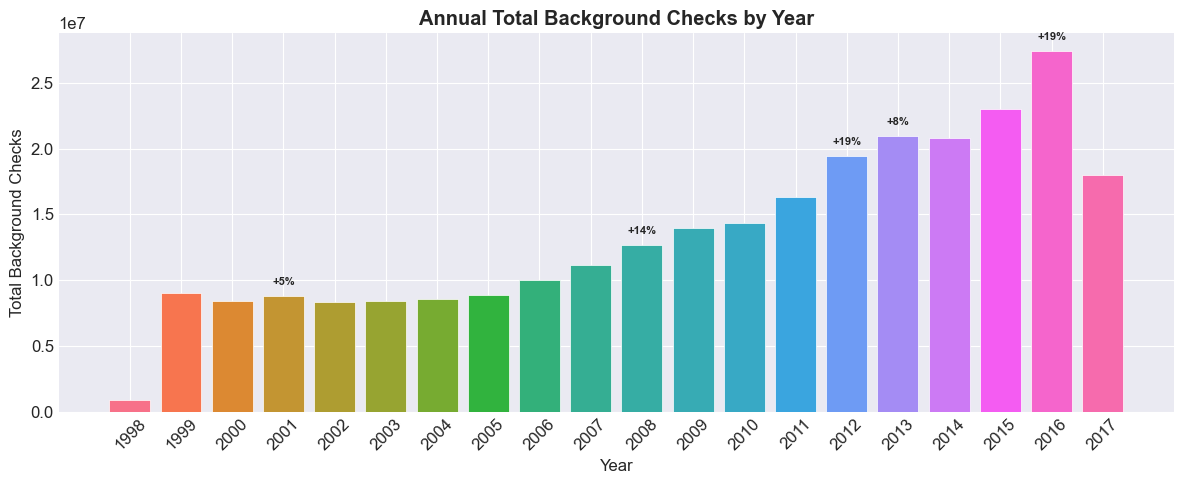

Overall growth from 1999 to 2017: 99%


In [21]:
# Annual totals
annual_totals = gun_df.groupby('year')['totals'].sum()

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(annual_totals.index, annual_totals.values, color=sns.color_palette('husl', len(annual_totals)),
              edgecolor='white', linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Total Background Checks')
ax.set_title('Annual Total Background Checks by Year', fontweight='bold')
ax.set_xticks(annual_totals.index)
ax.set_xticklabels(annual_totals.index, rotation=45)

# Add growth rate annotations for select years
growth = annual_totals.pct_change() * 100
for year in [2001, 2008, 2012, 2013, 2016]:
    if year in growth.index and not np.isnan(growth[year]):
        ax.annotate(f'{growth[year]:+.0f}%',
                    xy=(year, annual_totals[year]),
                    xytext=(0, 8), textcoords='offset points',
                    ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print(f'Overall growth from {annual_totals.index[1]} to {annual_totals.index[-1]}: '
      f'{((annual_totals.iloc[-1] / annual_totals.iloc[1]) - 1) * 100:.0f}%')

In [22]:
# Seasonal patterns: average checks by calendar month
seasonal = gun_df.groupby('month_num')['totals'].mean()
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(seasonal.index, seasonal.values, color='steelblue', edgecolor='white')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_labels)
ax.set_xlabel('Month')
ax.set_ylabel('Average Background Checks per State')
ax.set_title('Seasonal Pattern: Average Monthly Background Checks', fontweight='bold')
plt.tight_layout()
plt.show()

A clear seasonal pattern emerges: background checks tend to peak in **December** and **November**, likely driven by holiday gift purchases and hunting season. The lowest months tend to be in the **February–April** range.

---

### Research Question 2: Which states have the highest per-capita background check rates, and how do regions compare?

In [23]:
# Top 10 and bottom 10 states by per-capita checks
sorted_states = merged_df.sort_values('checks_per_100k', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top 10
top10 = sorted_states.tail(10)
axes[0].barh(top10['state'], top10['checks_per_100k'], color='indianred', edgecolor='white')
axes[0].set_xlabel('Background Checks per 100k Population')
axes[0].set_title('Top 10 States (Per Capita)', fontweight='bold')

# Bottom 10
bottom10 = sorted_states.head(10)
axes[1].barh(bottom10['state'], bottom10['checks_per_100k'], color='steelblue', edgecolor='white')
axes[1].set_xlabel('Background Checks per 100k Population')
axes[1].set_title('Bottom 10 States (Per Capita)', fontweight='bold')

plt.tight_layout()
plt.show()

Kentucky stands out dramatically due to its practice of running monthly permit rechecks through NICS, massively inflating its total count. Beyond Kentucky, states with high per-capita rates tend to be less densely populated and more rural.

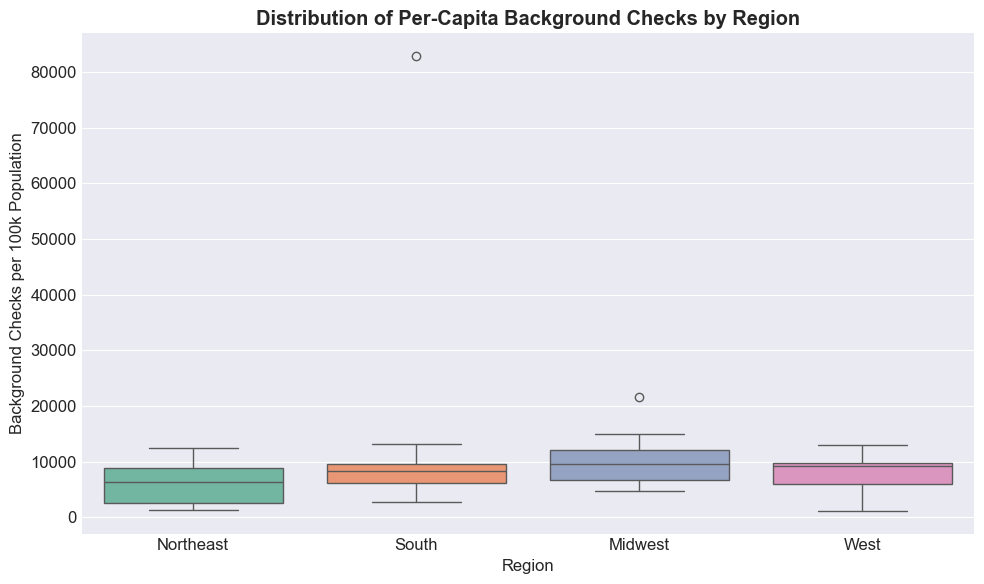

count          mean           std          min           max
region                                                                 
Midwest     12.0  10189.246813   4750.416811  4649.061725  21660.086238
Northeast    9.0   6027.877288   3856.985624  1362.327937  12373.735293
South       16.0  12734.434888  18893.102675  2748.582344  82868.346761
West        13.0   8323.281276   3178.110757  1167.681794  13077.638798

In [24]:
# Regional comparison box plot
fig, ax = plt.subplots(figsize=(10, 6))
region_order = ['Northeast', 'South', 'Midwest', 'West']
sns.boxplot(data=merged_df, x='region', y='checks_per_100k', order=region_order,
            palette='Set2', ax=ax)
ax.set_xlabel('Region')
ax.set_ylabel('Background Checks per 100k Population')
ax.set_title('Distribution of Per-Capita Background Checks by Region', fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics by region
merged_df.groupby('region')['checks_per_100k'].describe()[['count', 'mean', 'std', 'min', 'max']]

Regional differences are visible, though there is wide variation within each region. The **South** appears to have a higher median per-capita rate (influenced in part by Kentucky's inflated numbers), while the **Northeast** tends to have lower rates. However, the large within-group variation suggests that state-level factors matter more than broad regional membership.

---

### Research Question 3: What demographic and economic factors are associated with per-capita background check rates?

We examine correlations between per-capita background checks and census variables. To avoid Kentucky's extreme outlier effect from its permit recheck policy, we exclude it from correlation analysis.

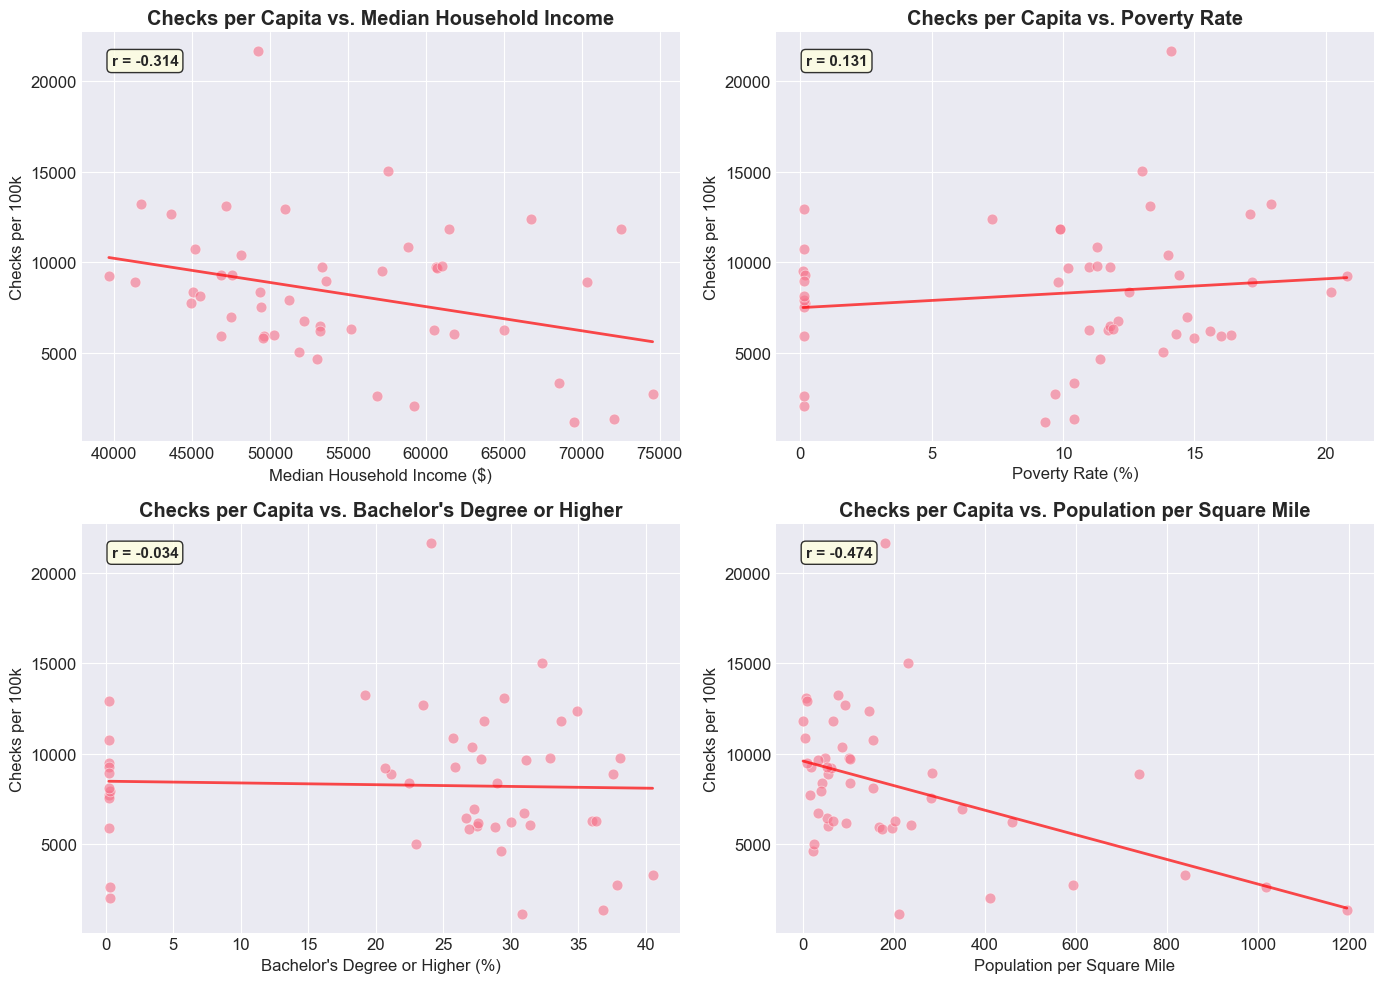

In [25]:
# Exclude Kentucky for correlation analysis (massive outlier due to permit rechecks)
corr_df = merged_df[merged_df['state'] != 'Kentucky'].copy()

# Scatter plots: per-capita checks vs. 4 census variables (using reusable function)
census_vars = [
    ('median_income', 'Median Household Income ($)'),
    ('poverty_rate', 'Poverty Rate (%)'),
    ('pct_bachelors', 'Bachelor\'s Degree or Higher (%)'),
    ('pop_per_sq_mile', 'Population per Square Mile')
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (var, label) in enumerate(census_vars):
    x = corr_df[var].dropna()
    y = corr_df.loc[x.index, 'checks_per_100k']
    plot_scatter_with_regression(axes[i], x, y, label, 'Checks per 100k',
                                f'Checks per Capita vs. {label.split("(")[0].strip()}')

plt.tight_layout()
plt.show()

Several patterns emerge from the scatter plots (excluding Kentucky):

- **Median income** appears to have a weak or unclear relationship with per-capita check rates.
- **Poverty rate** shows a tendency toward a positive association — states with higher poverty rates tend to have somewhat higher per-capita check rates, though the relationship is noisy.
- **Education level (% bachelor's degree)** tends to show a negative correlation — states with higher educational attainment appear to have lower per-capita check rates.
- **Population density** shows a negative correlation — more densely populated (urban) states tend to have fewer per-capita checks, consistent with higher check rates in rural states.

These are observational correlations only and do not imply causation. Many confounding factors (gun laws, cultural attitudes, urbanization) are at play.

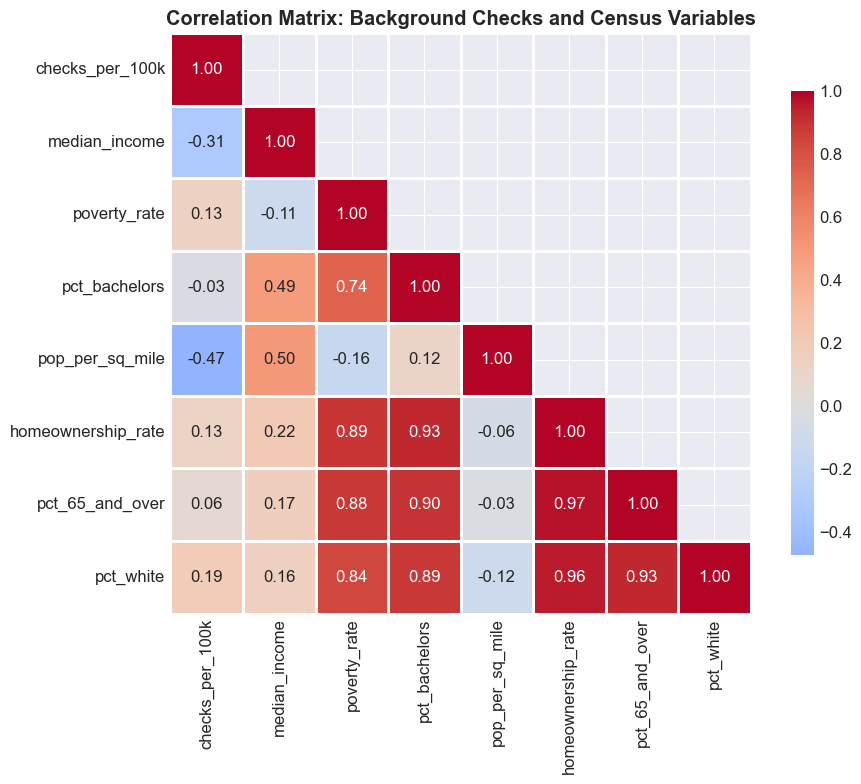

In [26]:
# Correlation heatmap
corr_vars = ['checks_per_100k', 'median_income', 'poverty_rate',
             'pct_bachelors', 'pop_per_sq_mile', 'homeownership_rate',
             'pct_65_and_over', 'pct_white']

# Keep only columns that exist
available_vars = [v for v in corr_vars if v in corr_df.columns]
corr_matrix = corr_df[available_vars].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Matrix: Background Checks and Census Variables', fontweight='bold')
plt.tight_layout()
plt.show()

The correlation heatmap summarizes the multivariate relationships at a glance. Population density and education appear to have the strongest negative associations with per-capita background check rates, while poverty rate and percentage of white population tend to show positive associations. Note that many census variables are themselves correlated (e.g., income and education), so these patterns should be interpreted cautiously.

---

### Research Question 4: How do handgun vs. long gun check proportions vary across states and over time?

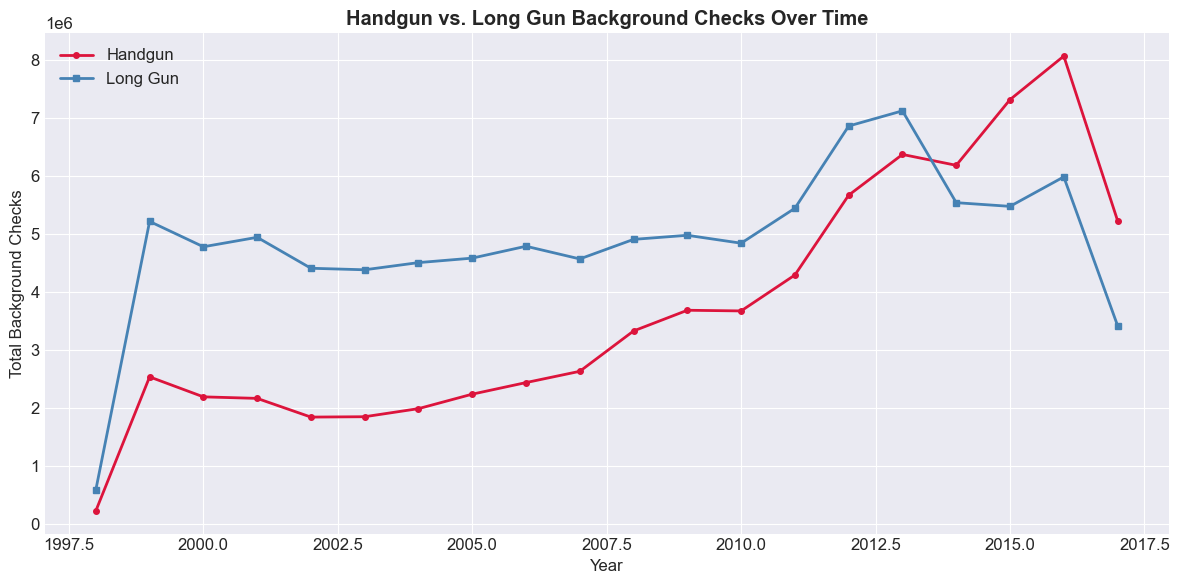

Handgun share of handgun+long_gun checks by year:
year
1998    0.273715
1999    0.326826
2000    0.314023
2001    0.304256
2002    0.294302
2003    0.296273
2004    0.305741
2005    0.327740
2006    0.337040
2007    0.365217
2008    0.403973
2009    0.425276
2010    0.431314
2011    0.440816
2012    0.452365
2013    0.472119
2014    0.527495
2015    0.572009
2016    0.574195
2017    0.604760


In [27]:
# Handgun vs. long gun national trends over time
type_trends = gun_df.groupby('year')[['handgun', 'long_gun']].sum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(type_trends.index, type_trends['handgun'], marker='o', markersize=4,
        linewidth=2, label='Handgun', color='crimson')
ax.plot(type_trends.index, type_trends['long_gun'], marker='s', markersize=4,
        linewidth=2, label='Long Gun', color='steelblue')
ax.set_xlabel('Year')
ax.set_ylabel('Total Background Checks')
ax.set_title('Handgun vs. Long Gun Background Checks Over Time', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

# Ratio analysis
type_trends['handgun_ratio'] = type_trends['handgun'] / (type_trends['handgun'] + type_trends['long_gun'])
print('Handgun share of handgun+long_gun checks by year:')
print(type_trends['handgun_ratio'].to_string())

Both handgun and long gun checks have increased over time, but handgun checks appear to have grown at a faster rate in recent years, suggesting a gradual shift in the composition of background checks. By 2016–2017, handgun checks surpass long gun checks nationally.

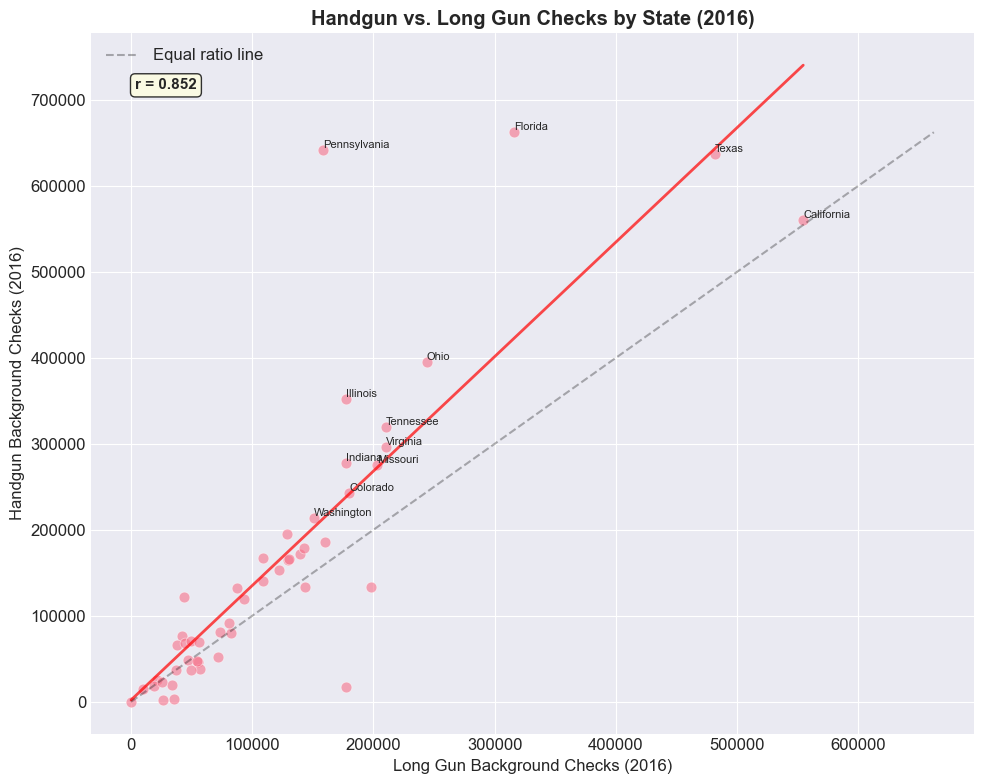

In [28]:
# Handgun vs. long gun by state (2016) — using reusable scatter function
fig, ax = plt.subplots(figsize=(10, 8))

plot_scatter_with_regression(ax, merged_df['long_gun'], merged_df['handgun'],
                             'Long Gun Background Checks (2016)',
                             'Handgun Background Checks (2016)',
                             'Handgun vs. Long Gun Checks by State (2016)')

# Label outlier states
for _, row in merged_df.iterrows():
    if row['handgun'] > 200000 or row['long_gun'] > 200000:
        ax.annotate(row['state'], (row['long_gun'], row['handgun']),
                    fontsize=8, ha='left', va='bottom')

# Add diagonal reference line (equal handgun and long gun)
max_val = max(merged_df['handgun'].max(), merged_df['long_gun'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Equal ratio line')
ax.legend()

plt.tight_layout()
plt.show()

Most states cluster along the diagonal, indicating a roughly proportional relationship between handgun and long gun checks. Larger states (Texas, Florida, California, Pennsylvania) naturally have higher absolute counts. States above the diagonal line have proportionally more handgun checks, while those below have more long gun checks.

---

<a id='conclusions'></a>
## Conclusions

### Key Findings

**1. Strong upward trend in background checks (RQ1):**  
FBI NICS background checks increased substantially from 1999 to 2017, with the rolling average showing near-continuous growth. Notable spikes appear to coincide with major political events such as presidential elections (2008, 2016) and the Sandy Hook shooting (December 2012). A consistent seasonal pattern shows peaks in November–December, likely tied to holiday purchases and hunting season.

**2. Significant geographic variation (RQ2):**  
Per-capita background check rates vary enormously across states. Kentucky is a dramatic outlier due to its practice of running monthly permit rechecks through NICS. Excluding Kentucky, states with higher per-capita rates tend to be less densely populated and more rural. Regional differences exist, but the variation within regions is often larger than the variation between them.

**3. Demographic and economic correlations (RQ3):**  
Per-capita background check rates appear to be negatively associated with population density and educational attainment, and positively associated with poverty rates. These correlations are modest and subject to many confounding factors including state gun laws, cultural attitudes, and urbanization patterns. **These are correlational findings only and should not be interpreted as causal.**

**4. Shifting check type composition (RQ4):**  
While both handgun and long gun checks have grown over the study period, handgun checks have grown at a faster rate and now surpass long gun checks nationally. This may reflect changing consumer preferences, though the data cannot distinguish between actual purchases and other check types.

### Limitations

1. **Background checks are not equivalent to gun sales.** A single background check can cover multiple firearms, and some checks are for permits or permit renewals that do not result in a sale. Conversely, private sales in many states do not require background checks. Therefore, NICS data is a proxy measure, not a direct count of firearm transactions.

2. **State-level policies create measurement artifacts.** Kentucky’s practice of monthly permit rechecks massively inflates its totals. Other states with varying permit requirements similarly affect comparisons.

3. **Census data represents a single point in time.** The demographic and economic variables come from a census snapshot (2015–2016 estimates), while the gun data spans nearly two decades. Demographic changes over that period are not captured.

4. **Correlation does not imply causation.** The relationships observed between census variables and background check rates are associational. Many confounding variables (gun legislation, cultural factors, political climate) are not controlled for.

5. **State-level aggregation masks within-state variation.** Urban and rural areas within the same state may have very different patterns, but this granularity is not available in the dataset.

### Future Research Directions

- Incorporate state-level gun legislation data to control for regulatory effects.
- Use county-level data for finer geographic resolution.
- Apply time-varying census estimates to better match the temporal dimension of the gun data.
- Employ causal inference methods (e.g., difference-in-differences) to assess the impact of policy changes on background check volume.

In [29]:
# Export to HTML
!jupyter nbconvert --to html Investigate_a_Dataset.ipynb

[NbConvertApp] Converting notebook Investigate_a_Dataset.ipynb to html


[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).


[NbConvertApp] Writing 951771 bytes to Investigate_a_Dataset.html
